In [80]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from cca import ComplexityComponentsAnalysis as CCA
from cca.cov_util import calc_cov_from_cross_cov_mats
from cca.methods_comparison import SlowFeatureAnalysis as SFA

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as LR

import statsmodels.api as sm
from statsmodels.formula.api import ols

import dabest

from scipy.signal import resample
from scipy.stats import wilcoxon
from matplotlib.cm import plasma

In [2]:
df = pd.read_csv('weather/temperature.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df = df[['Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston']]
df = df.dropna(axis=0, how='any')
dts = (df.index[1:] - df.index[:-1]).to_numpy()
df = df.iloc[np.nonzero(dts > dts.min())[0].max() + 1:]
n_cities = len(df.columns)

In [3]:
df

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-02 15:00:00,273.45,273.84,279.79,272.38,279.68,279.54,272.96,276.73,269.42,261.04,...,268.22,288.04,281.35,298.05,275.93,270.13,277.86,277.57,272.04,279.66
2014-02-02 16:00:00,273.28,273.87,279.77,272.43,282.01,280.54,275.93,280.37,272.41,262.87,...,268.71,289.27,284.51,296.52,275.69,270.46,279.92,281.20,272.10,281.96
2014-02-02 17:00:00,274.14,274.26,279.85,273.33,284.56,283.04,277.94,283.87,274.23,265.45,...,268.95,290.01,286.66,297.94,275.62,270.47,281.48,282.87,272.27,283.56
2014-02-02 18:00:00,274.71,275.29,279.79,274.85,286.48,285.85,279.17,286.29,276.63,267.35,...,269.26,291.71,289.13,299.74,275.11,270.73,283.43,284.33,272.04,284.02
2014-02-02 19:00:00,275.32,276.87,279.96,276.19,287.18,288.27,280.58,288.07,278.31,268.63,...,269.47,293.32,291.09,300.14,274.41,270.89,284.46,284.32,271.45,283.14
2014-02-02 20:00:00,275.96,277.94,280.83,277.65,288.00,289.16,281.06,288.79,279.41,269.73,...,269.49,294.40,292.50,300.12,273.63,270.77,284.65,283.77,271.51,281.26
2014-02-02 21:00:00,276.91,279.05,281.15,278.73,288.78,289.53,281.99,289.70,280.30,269.35,...,269.18,294.45,293.04,299.36,273.20,270.86,284.34,283.45,271.31,280.45
2014-02-02 22:00:00,277.23,280.05,281.36,279.32,288.34,289.21,282.46,290.07,280.79,268.89,...,268.82,294.18,292.30,298.77,272.80,270.30,282.63,282.28,270.97,279.79
2014-02-02 23:00:00,277.43,280.50,281.90,279.23,287.61,288.98,282.18,289.75,280.64,267.96,...,268.10,292.69,290.26,297.88,272.35,269.63,281.29,280.92,270.69,279.26


In [4]:
Xfs = df.values.copy()

In [5]:
ds_factor = 24
X = resample(Xfs, Xfs.shape[0] // ds_factor, axis=0)
X -= X.mean(axis=0, keepdims=True)

In [47]:
T_pi = 5
compare = 'PCA'

In [48]:
def eval(trainp, trainf, testp, testf, lags):
    results = np.zeros((lags.size, 2))
    for ii, lag in enumerate(lags):
        model = LR(fit_intercept=False).fit(trainp[:-lag], trainf[lag:])
        results[ii] = model.score(trainp[:-lag], trainf[lag:]), model.score(testp[:-lag], testf[lag:])
    return results

In [49]:
n_samples = X.shape[0]
split_idx = int(n_samples * .9)
train = X[:split_idx - T_pi]
test = X[split_idx + T_pi:]
train_mean = train.mean(axis=0, keepdims=True)
train_std = train.std(axis=0, keepdims=True)
train -= train_mean
train /= train_std
test -= train_mean
test /= train_std

In [50]:
dims = np.arange(2, 15, 2)
lags = np.array([3, 7, 15, 23, 30])

results = np.zeros((2, dims.size, lags.size, 2))

dca_model = CCA(T=T_pi)
dca_model.estimate_cross_covariance(train) #, regularization='kron')

for ii, d in enumerate(dims):
    if compare == 'PCA':
        comp_model = PCA(d).fit(train)
    elif compare == 'SFA':
        comp_model = SFA(d).fit(train)
    trainp = comp_model.transform(train)
    testp = comp_model.transform(test)
    results[0, ii] = eval(trainp, train, testp, test, lags)
    dca_model.fit_projection(d=d)
    trainp = dca_model.transform(train)
    testp = dca_model.transform(test)
    results[1, ii] = eval(trainp, train, testp, test, lags)

In [58]:
results_df = pd.DataFrame(results[:, :, :, 1].reshape(2, -1).T, columns=[compare, 'DCA'])

In [59]:
results_df['ID'] = np.arange(results_df.shape[0])
results_df['dim'] = np.tile(dims[:, np.newaxis], (1, lags.size)).ravel()
results_df['lag'] = np.tile(lags[np.newaxis, :], (dims.size, 1)).ravel()

In [60]:
two_groups_paired = dabest.load(results_df, idx=(compare, 'DCA'),
                                resamples=5000, paired=True,
                                id_col='ID')

,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,PCA,DCA,mean difference,True,0.033333,95,0.003983,0.068028,6.382803e-07,11.0,3.744553e-07,-6.27937


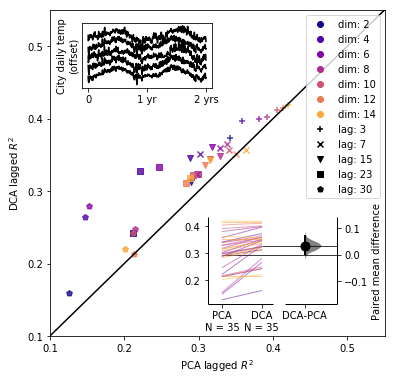

In [54]:
f, ax = plt.subplots(1, figsize=(6, 6))

ax_temp = f.add_axes([.2, .7, .3, .15])
ax_temp.plot(X[:2 * 365*24 // ds_factor, :5] + np.linspace(0, 10, 5)[np.newaxis], c='k')
ax_temp.set_xticks([0, 365*24 // ds_factor, 2*365*24 // ds_factor])
ax_temp.set_xticklabels([0, '1 yr', '2 yrs'])
ax_temp.set_yticks([])
ax_temp.set_ylabel('City daily temp\n(offset)')

markers = ['+', 'x', 'v', 's', 'p']
cs = plasma(np.linspace(0, .8, dims.size))
for ii, d in enumerate(dims):
    for jj, l in enumerate(lags):
        ax.scatter(results[0, ii, jj, 1].ravel(), results[1, ii, jj, 1].ravel(),
                   marker=markers[jj], c=[cs[ii]], alpha=.8)
for ii, d in enumerate(dims):
    label = 'dim: {}'.format(d)
    ax.scatter(-1, -1, label=label, marker='o', c=[cs[ii]])
for jj, l in enumerate(lags):
    label = 'lag: {}'.format(l)
    ax.scatter(-1, -1, label=label, marker=markers[jj], c='k')

ax_slope = f.add_axes([.49, .2, .15, .2])
ax_diff = f.add_axes([.64, .2, .15, .2])

two_groups_paired.mean_diff.plot(color_col='dim', custom_palette='plasma',
                                 swarm_desat=1., halfviolin_alpha=1.,
                                 faxx=(f, (ax_slope, ax_diff)), no_legend=True)

minr2 = .1
maxr2 = .55
ax.plot([minr2, maxr2], [minr2, maxr2], c='k')
ax.set_xlim(minr2, maxr2)
ax.set_ylim(minr2, maxr2)
ax.legend(loc='upper right')
ax.set_xlabel(r'PCA lagged $R^2$')
ax.set_ylabel(r'DCA lagged $R^2$')
two_groups_paired.mean_diff.statistical_tests
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/weather_forcasting.pdf'), dpi=300)

In [66]:
results_df2 = pd.concat([results_df[['dim', 'lag']], results_df[['dim', 'lag']]])

In [81]:
results_df2['value'] = pd.concat([results_df['DCA'], results_df['PCA']])
results_df2['model'] = np.concatenate([np.ones_like(results_df['PCA'], dtype=int),
                                       np.zeros_like(results_df['PCA'], dtype=int)])

In [88]:
r2_lm = ols('value ~ C(model) + dim + lag', results_df2).fit()

In [89]:
print(r2_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     125.3
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           3.41e-27
Time:                        08:57:45   Log-Likelihood:                 153.35
No. Observations:                  70   AIC:                            -298.7
Df Residuals:                      66   BIC:                            -289.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3582      0.010     36.979

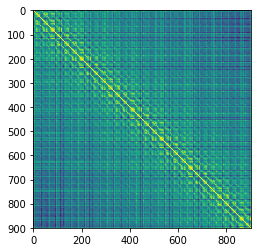

In [88]:
plt.imshow(calc_cov_from_cross_cov_mats(dca_model.cross_covs))

In [28]:
dca_model2 = CCA(T=T_pi)
dca_model2.estimate_cross_covariance(train, regularization='kron')

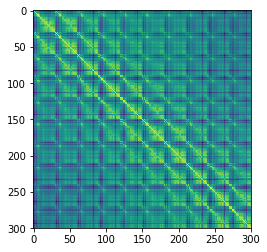

In [14]:
plt.imshow(calc_cov_from_cross_cov_mats(dca_model2.cross_covs))

In [80]:
pm = PCA(5)
x5 = pm.fit_transform(X)

In [81]:
model = CCA(d=1, T=1)

In [82]:
model.estimate_cross_covariance(X, regularization='kron')
model.fit_projection()

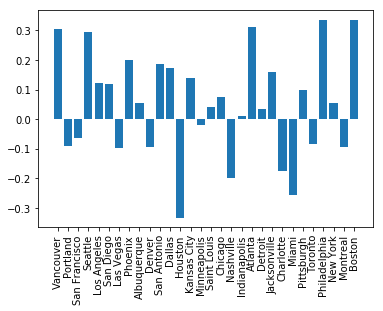

In [83]:
f, ax = plt.subplots()
ax.bar(np.arange(n_cities), model.coef_.squeeze())
ax.set_xticks(np.arange(n_cities))
ax.set_xticklabels(df.columns, rotation='vertical')
plt.show()

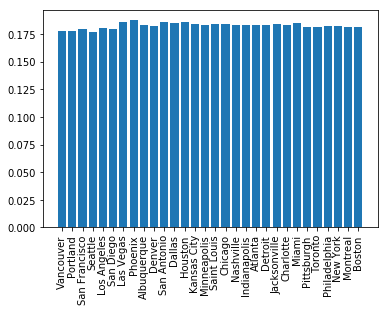

In [84]:
f, ax = plt.subplots()
ax.bar(np.arange(n_cities), pm.components_[0].squeeze())
ax.set_xticks(np.arange(n_cities))
ax.set_xticklabels(df.columns, rotation='vertical')
plt.show()

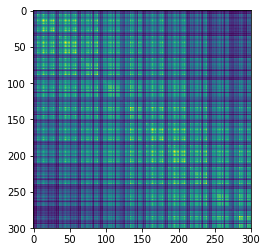

In [125]:
plt.imshow(calc_cov_from_cross_cov_mats(model.cross_covs))

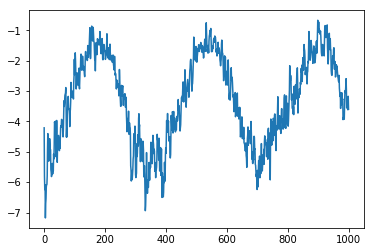

In [85]:
plt.plot(model.transform(X)[:1000])

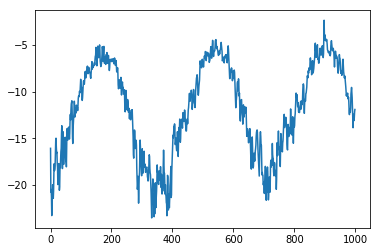

In [88]:
plt.plot(pm.transform(X)[:1000, 0])